<div class="alert alert-warning">
<h2> СОВЕТ <a class="tocSkip"> </h2>
большинство графиков здесь интерактивные советую смотреть через nbviewer
</div>

#  Прогнозирование показателей счётчика

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение prophet" data-toc-modified-id="Обучение prophet-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение prophet </a></span></li><li><span><a href="#Обучение rnn" data-toc-modified-id="Обучение rnn-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение rnn</a></span></li>
<li><span><a href="#Обучение CatBoost" data-toc-modified-id="Обучение CatBoost-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение CatBoost</a></span></li>
<li><span><a href="#Интерпретация CatBoostRegressor" data-toc-modified-id="Интерпретация CatBoostRegressor-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Интерпретация CatBoostRegressor</a></span></li>
<li><span><a href="#Итоговый тест и вывод" data-toc-modified-id="Итоговый тест и вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Итоговый тест и вывод</a></span></li></ul></div>

Задача

1. Сделать прогноз временного ряда на следующие сутки. 
2. Выбрать метрику, оценить результат прогноза. 
3. Выполнить поиск аномальных значений временного ряда.
4. Построить на одном графике: временной ряд, прогноз, аномальные точки. 

Данные

`counter_timestamp` - дата и время  
`counter_data` - значения счетчика


In [1]:
pip install shap==0.40.0

Note: you may need to restart the kernel to use updated packages.


## Подготовка

In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objects as go
from ydata_profiling import ProfileReport
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from prophet import Prophet
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense,LSTM
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from catboost import CatBoostRegressor
import shap
%pylab inline

2023-09-07 15:08:23.463785: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 15:08:23.495970: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 15:08:23.496964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 15:08:24.408144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy


In [3]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
data = pd.read_csv('performance_data.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data

counter_data
counter_timestamp                
2022-02-21 16:15:00  10408.421667
2022-02-21 16:30:00  10493.064667
2022-02-21 16:45:00  10370.143667
2022-02-21 17:00:00  11169.873000
2022-02-21 17:15:00  11111.825000
...                           ...
2022-03-22 23:00:00           NaN
2022-03-22 23:15:00   1993.071000
2022-03-22 23:30:00   1573.885667
2022-03-22 23:45:00   1005.688000
2022-03-23 00:00:00   1618.347667

[2806 rows x 1 columns]

сразу в глаза бросается пропуск.
<br>пропуск - это аномалия , будем их фиксировать

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2806 entries, 2022-02-21 16:15:00 to 2022-03-23 00:00:00
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   counter_data  2778 non-null   float64
dtypes: float64(1)
memory usage: 43.8 KB


In [6]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

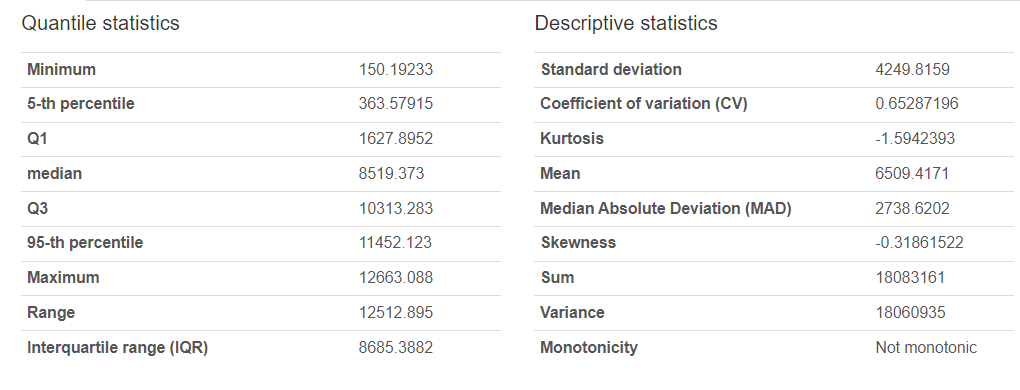

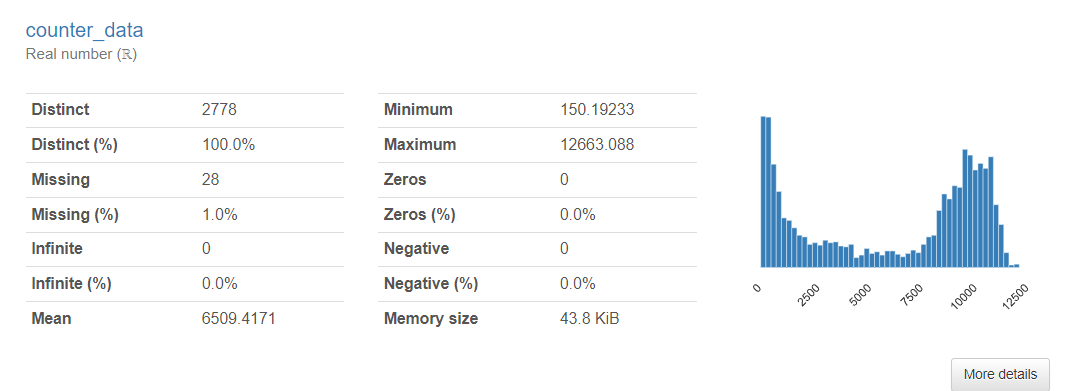

в выводе по блоку опишу то что вижу 

на всякий случай проверим что бед с индексом нет

In [7]:
data.index.is_monotonic

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.


True

In [8]:
fig = px.line(data, x=data.index, y='counter_data', title='counter results')

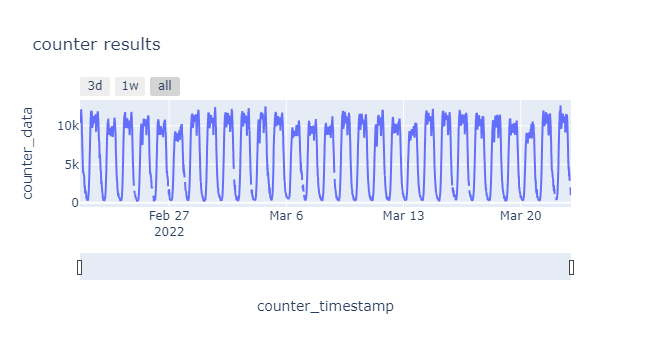

In [9]:
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"), # добавляем кнопки на график позволяющие менять быстро диапазон наблюдений
            dict(count=7, label="1w", step="day", stepmode="backward"), # добавляем кнопки на график позволяющие менять быстро диапазон наблюдений
            dict(step="all")
        ])
    )
)
fig.show()


наблюдение: в основном пропуски найденны ночью (причём до полуночи) я не знаю процессов , но могу предположить что были какие-то технические работы или открлючения детекции по другим причинам . Также это может говорить об определённых неисправностях 

<div class="alert alert-info">
<h2> Комментарий выполняющего: <a class="tocSkip"> </h2>
важно, всё что я говорю это лишь рассуждения без знания самого процесса
</div> 

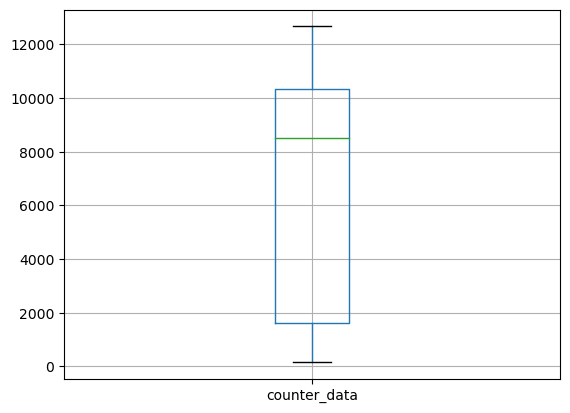

In [10]:
data.boxplot()
plt.show()

угу , выбросов нет 

In [11]:
index_nan = data[data['counter_data'].isna()]
index_nan

counter_data
counter_timestamp                
2022-02-24 21:45:00           NaN
2022-02-24 22:00:00           NaN
2022-02-25 23:45:00           NaN
2022-02-26 00:30:00           NaN
2022-02-26 00:45:00           NaN
2022-02-26 01:00:00           NaN
2022-02-26 22:45:00           NaN
2022-02-26 23:00:00           NaN
2022-02-27 22:30:00           NaN
2022-02-27 23:45:00           NaN
2022-02-28 00:00:00           NaN
2022-02-28 03:00:00           NaN
2022-03-01 23:00:00           NaN
2022-03-02 21:00:00           NaN
2022-03-03 21:45:00           NaN
2022-03-06 23:00:00           NaN
2022-03-07 01:00:00           NaN
2022-03-08 21:00:00           NaN
2022-03-15 22:00:00           NaN
2022-03-16 01:30:00           NaN
2022-03-16 02:00:00           NaN
2022-03-16 22:00:00           NaN
2022-03-22 00:00:00           NaN
2022-03-22 00:45:00           NaN
2022-03-22 01:45:00           NaN
2022-03-22 22:30:00           NaN
2022-03-22 22:45:00           NaN
2022-03-22 23:00:00           NaN

заполнение пропусков интерполяцией

In [12]:
data = data.interpolate(method='polynomial', order=2)

сохранение в отдельный датасет точек с выбросами , для дальнейшего вывода на графики

In [13]:
data_out = data[data.index.isin(index_nan.index)]
data_out

counter_data
counter_timestamp                
2022-02-24 21:45:00   1953.690541
2022-02-24 22:00:00   1800.421594
2022-02-25 23:45:00   2032.563663
2022-02-26 00:30:00   1760.398560
2022-02-26 00:45:00   1484.355495
2022-02-26 01:00:00   1178.610266
2022-02-26 22:45:00   1412.645006
2022-02-26 23:00:00   1092.715985
2022-02-27 22:30:00   3048.080574
2022-02-27 23:45:00   1331.993885
2022-02-28 00:00:00   1482.417188
2022-02-28 03:00:00    317.292051
2022-03-01 23:00:00   1129.299517
2022-03-02 21:00:00   3761.077590
2022-03-03 21:45:00   2004.963625
2022-03-06 23:00:00   2633.438720
2022-03-07 01:00:00   1245.226422
2022-03-08 21:00:00   3469.207707
2022-03-15 22:00:00   2241.448301
2022-03-16 01:30:00    878.771563
2022-03-16 02:00:00   1052.485598
2022-03-16 22:00:00   1825.889382
2022-03-22 00:00:00   2352.480024
2022-03-22 00:45:00    755.539100
2022-03-22 01:45:00    552.839436
2022-03-22 22:30:00   2754.918479
2022-03-22 22:45:00   2565.626590
2022-03-22 23:00:00   2308.405240

In [14]:
data.isna().sum()

counter_data    0
dtype: int64

отлично устранили пропуски, взляним на пропуски

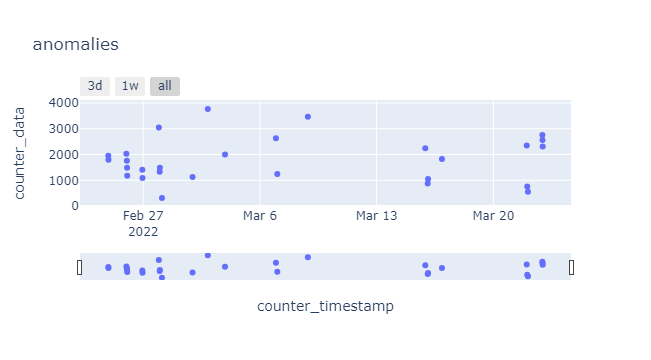

In [15]:
#fig = px.line(data, x=data.index, y='counter_data', title='num_orders for all the time')
fig = px.scatter(data_out, x=data_out.index, y='counter_data', title='anomalies')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"),
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

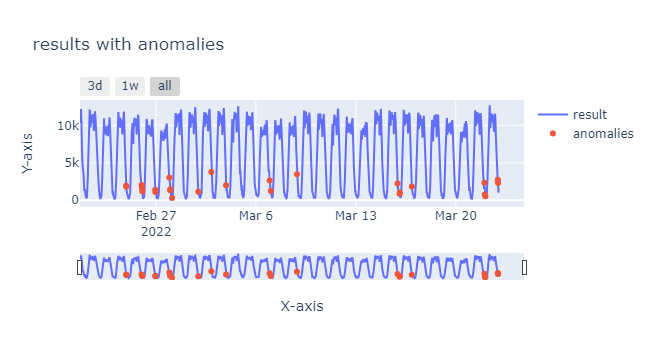

In [16]:
# Sample data
x_data1 = x=data.index
x_data2 = data_out.index
y_data_1 = data['counter_data']
y_data_2 = data_out['counter_data']

# Create traces for each data set
trace1 = go.Scatter(x=x_data1, y=y_data_1, mode='lines', name='result')
trace2 = go.Scatter(x=x_data2, y=y_data_2, mode='markers', name='anomalies')

# Create the figure and add traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout if needed (e.g., title, axis labels)
fig.update_layout(title='results with anomalies',
                  xaxis_title='X-axis',
                  yaxis_title='Y-axis')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"),
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

Вывод EDA + заполнения: 
<br>проблем с типом данных нет (индекс - data , значение - float) 
<br>в столбцах которые будем использовать для построение моделей было обнаруженно и заполено интерполяцией 28 пропусков 
<br>явные дубликаты отсутствуют 
<br>странных значений обнаружено не было (нет значений выбивающихся из временного ряда + нарушающие сезонность , также нет нулевых значений , минимальное и максимальное значение находится недалеко от 5 и 95 перцентиля соответсвенно , что говорит об отсутсвие экстремально больших или маленьких значений

Дальнейший план: проведём ресэмплинг и проверим на стационарность ряд

## Анализ

давайте проверим ряд на стационарность (визуально видно , что он стационарен , но вдруг мы что-то не правильно интерпретировали)

H0 : временной ряд содержит единичные корни, т.е., он нестационарен.
<br>H1 : временной ряд лишен единичных корней, т.е., он стационарен. 
<br>alpha = 0.05

In [17]:
result = adfuller(data['counter_data'])

In [18]:
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -13.660930614204668
p-value: 1.5219542949639704e-25
Critical Values: {'1%': -3.43270698773957, '5%': -2.862581350327331, '10%': -2.5673243433645037}


значение статистики ADF значительно меньше критических значений , это может свидетельствовать о стационарности временного ряда. Также  p-value меньше выбранного уровня значимости , это может указывать на стационарность временного ряда, и нулевую гипотезу о наличии единичных корней можно отвергнуть.

In [19]:
data

counter_data
counter_timestamp                
2022-02-21 16:15:00  10408.421667
2022-02-21 16:30:00  10493.064667
2022-02-21 16:45:00  10370.143667
2022-02-21 17:00:00  11169.873000
2022-02-21 17:15:00  11111.825000
...                           ...
2022-03-22 23:00:00   2308.405240
2022-03-22 23:15:00   1993.071000
2022-03-22 23:30:00   1573.885667
2022-03-22 23:45:00   1005.688000
2022-03-23 00:00:00   1618.347667

[2806 rows x 1 columns]

горизонт прогнозирования сутки , это 96 временных точек , ужас) нужен resample хотя бы почасовой. 24 Точки конечно не сок , но это и не почти 100)

In [20]:
data = data.resample('1H').sum()

In [21]:
data

counter_data
counter_timestamp                
2022-02-21 16:00:00  31271.630001
2022-02-21 17:00:00  45465.502000
2022-02-21 18:00:00  45091.751334
2022-02-21 19:00:00  31916.051666
2022-02-21 20:00:00  19101.347001
...                           ...
2022-03-22 20:00:00  19620.574334
2022-03-22 21:00:00  15462.083333
2022-03-22 22:00:00  11133.987069
2022-03-22 23:00:00   6881.049907
2022-03-23 00:00:00   1618.347667

[705 rows x 1 columns]

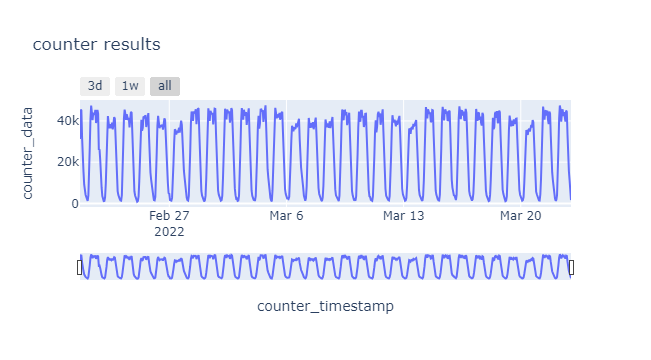

In [22]:
fig = px.line(data, x=data.index, y='counter_data', title='counter results')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"),
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

временной ряд не имеет визуальных изменений после resample , единственное что , интересный нюанс обычно счётчик имеет спад с приблизительно 18:00 до 2-3 часов ночи , как правило это происходит с плавным убыванием значения , но 22 февраля значение счётчика в 19 было больше чем в 18 
<br> 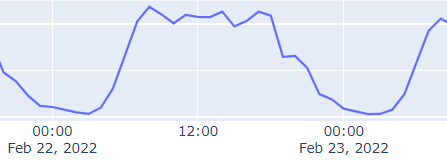

также нужно сопоставить аномалии с новым данными

In [23]:
data_out.index = data_out.index.floor('H')
data_out = data[data.index.isin(index_nan.index)]
data_out

counter_data
counter_timestamp                
2022-02-24 22:00:00   5889.760261
2022-02-26 01:00:00   3791.489266
2022-02-26 23:00:00   5023.265651
2022-02-28 00:00:00   5497.438521
2022-02-28 03:00:00   1384.188384
2022-03-01 23:00:00   4249.178517
2022-03-02 21:00:00  11472.199590
2022-03-06 23:00:00   8436.474720
2022-03-07 01:00:00   3832.774088
2022-03-08 21:00:00  11530.582040
2022-03-15 22:00:00   7677.866967
2022-03-16 02:00:00   3002.560597
2022-03-16 22:00:00   6127.690382
2022-03-22 00:00:00   6063.174790
2022-03-22 23:00:00   6881.049907

давайте убедимся что на графике всё выводит корректно 

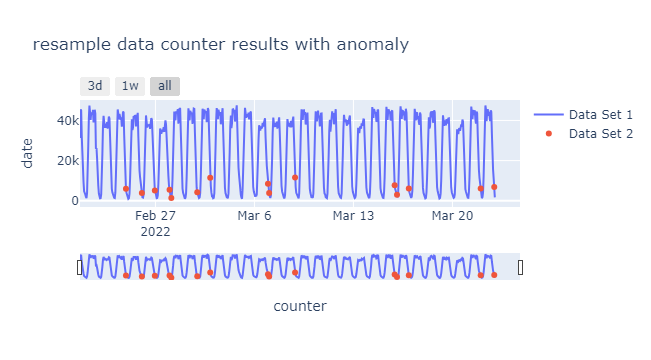

In [24]:
x_data1 = x=data.index
x_data2 = data_out.index
y_data_1 = data['counter_data']
y_data_2 = data_out['counter_data']

# Create traces for each data set
trace1 = go.Scatter(x=x_data1, y=y_data_1, mode='lines', name='Data Set 1')
trace2 = go.Scatter(x=x_data2, y=y_data_2, mode='markers', name='Data Set 2')

# Create the figure and add traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout if needed (e.g., title, axis labels)
fig.update_layout(title='resample data counter results with anomaly',
                  xaxis_title='counter',
                  yaxis_title='date')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"),
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

всё совпало , супер

осталось посмотреть сезонности и тренды с шумом , мне не особо нравится как работает seasonal_decompose , но что поделать

In [25]:
decomposed = seasonal_decompose(data)

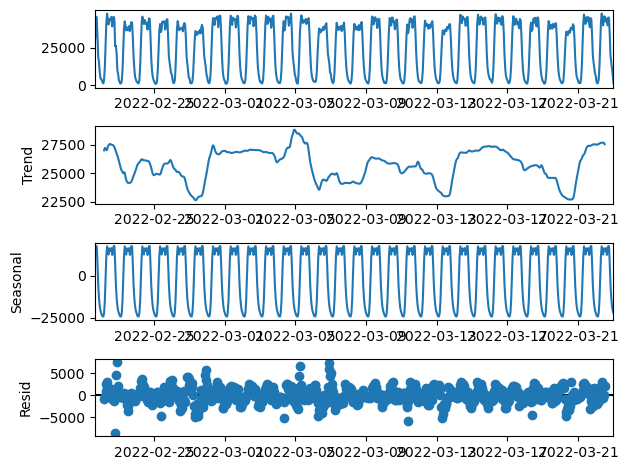

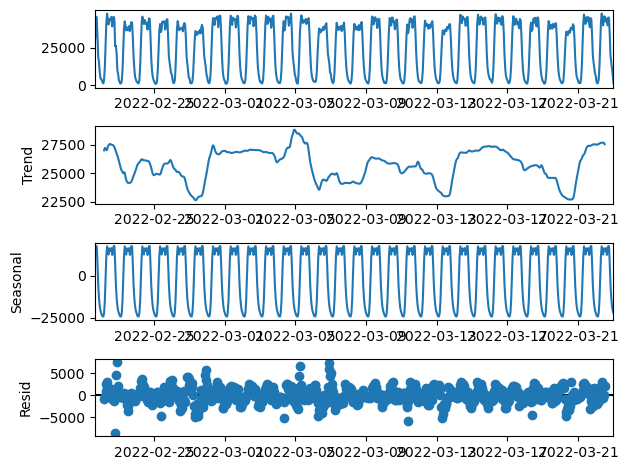

In [26]:
decomposed.plot()

чётко прослеживается сезонность (причём дневная и недельная) доп комментарий - нет , это не недельная сезонность , но у каждого дня есть свой паттерн , с чем он связан установить не удалось 

train + valid = trava

разбиенние на 4 выборки (валидация - 15% от общего объёма , тест - 15% от общего объёма)

In [27]:
y_tra_va, y_test = temporal_train_test_split(data,test_size = 0.15)
y_train, y_valid = temporal_train_test_split(y_tra_va,test_size = 0.176)

In [28]:
print(data.shape)
print(y_train.shape)
print(y_valid.shape)
y_test.shape

(705, 1)
(493, 1)
(106, 1)


(106, 1)

для начала сделаем наивные модели 1) будет давать значение прошлого часа 

In [29]:
forecast_data = y_train.copy()
forecast_data["Past_Value_Forecast"] = forecast_data["counter_data"].shift(1)
forecast_data = forecast_data.iloc[1:]
np.sqrt(mean_squared_error(forecast_data['counter_data'],forecast_data['Past_Value_Forecast']))

6147.837352138654

6100, плохой бэйзлайн

2) будет давать значение в это же время с прошлого дня 

In [30]:
forecast_data = y_train.copy()
forecast_data["Past_Value_Forecast"] = forecast_data["counter_data"].shift(24)
forecast_data = forecast_data.iloc[24:]
np.sqrt(mean_squared_error(forecast_data['counter_data'],forecast_data['Past_Value_Forecast']))

3221.6821820141536

3200 , звучит как то что можно будет Преодоле́ть 

3) будет давать значение в это же время в этот же день недели с прошлой недели 

In [31]:
forecast_data = y_train.copy()
forecast_data["Past_Value_Forecast"] = forecast_data["counter_data"].shift(168)
forecast_data = forecast_data.iloc[168:]
np.sqrt(mean_squared_error(forecast_data['counter_data'],forecast_data['Past_Value_Forecast']))

2904.3307435114266

ожидал что будет лучше , вообщем 2900 наш бэзлайн

<div class="alert alert-info">
<h2> Комментарий выполняющего: <a class="tocSkip"> </h2>
на всякий случай выбор метрики здесь
</div> 

выбор метрики: основные метрики которые мы можем использовать rmse , mae или mape. Смотрите у нас есть по сути два варианта rmse и mape.Что нам важнее? Наверное определить точнее когда нагрузка высокая (как мне кажется) , mae будет завышаться на ночьных сессиях (ошибка в 10ед днём будет иметь куда меньшей процент чем 10ед ночью) тоесть мы можем получить сильное завышение реальной ошибки. RMSE наоборот ночью занижается , но не в десятки раз , тоесть она стабильнее следовательно буду использовать именно rmse 

вывод анализа: у нас есть счётчик какого-то процесса имеющий дневную сезонность где спады и взлёты счётчика происходят примерно в одно и тоже время 
<br>больше аномалий зафиксированно не было 

## Обучение prophet

функция преобразующая данные в формат удобный профету

In [32]:
def hello_prophet(df):
    pr_df = df.reset_index()
    pr_df.columns = ['ds', 'y']
    return pr_df

In [33]:
data_prophet =  hello_prophet(data)
tra_va_prophet = hello_prophet(y_tra_va)
test_prophet = hello_prophet(y_test)
train_prophet = hello_prophet(y_train)
valid_prophet = hello_prophet(y_valid)

обучение профета

In [34]:
prophet_m = Prophet()
prophet_m.fit(train_prophet)

15:08:29 - cmdstanpy - INFO - Chain [1] start processing
15:08:29 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
forecast = prophet_m.predict(valid_prophet)

In [36]:
forecast

ds         trend    yhat_lower    yhat_upper  \
0   2022-03-14 05:00:00  24714.799574   8270.814710  15102.766638   
1   2022-03-14 06:00:00  24708.695981  20558.678061  27454.978050   
2   2022-03-14 07:00:00  24702.592389  30986.756685  37600.604157   
3   2022-03-14 08:00:00  24696.488796  35858.852031  42839.135835   
4   2022-03-14 09:00:00  24690.385203  36761.479582  43794.869285   
..                  ...           ...           ...           ...   
101 2022-03-18 10:00:00  24098.336705  36243.247963  43015.582540   
102 2022-03-18 11:00:00  24092.233113  35952.319422  42662.981500   
103 2022-03-18 12:00:00  24086.129520  36436.321582  43198.974975   
104 2022-03-18 13:00:00  24080.025927  36249.364456  43244.985731   
105 2022-03-18 14:00:00  24073.922334  35874.878010  42430.942392   

      trend_lower   trend_upper  additive_terms  additive_terms_lower  \
0    24714.799574  24714.799574   -13285.814446         -13285.814446   
1    24708.695981  24708.695981     -708.021244           -708.021244   
2    24702.592389  24702.592389     9616.027021           9616.027021   
3    24696.488796  24696.679012    14778.560793          14778.560793   
4    24690.288829  24690.837520    15582.036500          15582.036500   
..            ...           ...             ...                   ...   
101  23921.788891  24289.491935    15323.934367          15323.934367   
102  23911.893287  24286.311656    15293.680045          15293.680045   
103  23900.681750  24282.564238    15811.405254          15811.405254   
104  23891.299587  24278.594079    15775.750381          15775.750381   
105  23885.435468  24277.123272    15074.867256          15074.867256   

     additive_terms_upper         daily   daily_lower   daily_upper  \
0           -13285.814446 -12750.932928 -12750.932928 -12750.932928   
1             -708.021244   -305.972969   -305.972969   -305.972969   
2             9616.027021   9889.516964   9889.516964   9889.516964   
3            14778.560793  14928.820268  14928.820268  14928.820268   
4            15582.036500  15615.361337  15615.361337  15615.361337   
..                    ...           ...           ...           ...   
101          15323.934367  14859.535848  14859.535848  14859.535848   
102          15293.680045  14748.673081  14748.673081  14748.673081   
103          15811.405254  15185.246413  15185.246413  15185.246413   
104          15775.750381  15069.014529  15069.014529  15069.014529   
105          15074.867256  14289.269133  14289.269133  14289.269133   

         weekly  weekly_lower  weekly_upper  multiplicative_terms  \
0   -534.881517   -534.881517   -534.881517                   0.0   
1   -402.048274   -402.048274   -402.048274                   0.0   
2   -273.489944   -273.489944   -273.489944                   0.0   
3   -150.259475   -150.259475   -150.259475                   0.0   
4    -33.324837    -33.324837    -33.324837                   0.0   
..          ...           ...           ...                   ...   
101  464.398519    464.398519    464.398519                   0.0   
102  545.006963    545.006963    545.006963                   0.0   
103  626.158841    626.158841    626.158841                   0.0   
104  706.735852    706.735852    706.735852                   0.0   
105  785.598122    785.598122    785.598122                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                           0.0                         0.0  11428.985129  
1                           0.0                         0.0  24000.674738  
2                           0.0                         0.0  34318.619409  
3                           0.0                         0.0  39475.049589  
4                           0.0                         0.0  40272.421703  
..                          ...                         ...           ...  
101                         0.0                         0.0  39422.271073  
102                      

создание табличке в которой указано истинное и предугаданное значение

In [37]:
data_result = forecast[['ds','yhat']]
data_result['y'] = valid_prophet['y'].copy()
data_result = data_result.set_index(['ds'])
data_result

/tmp/ipykernel_75/1154026111.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



yhat             y
ds                                             
2022-03-14 05:00:00  11428.985129  11145.998000
2022-03-14 06:00:00  24000.674738  24871.138667
2022-03-14 07:00:00  34318.619409  39697.814666
2022-03-14 08:00:00  39475.049589  46679.943333
2022-03-14 09:00:00  40272.421703  44757.724667
...                           ...           ...
2022-03-18 10:00:00  39422.271073  36913.975000
2022-03-18 11:00:00  39385.913157  43621.235667
2022-03-18 12:00:00  39897.534774  44376.084333
2022-03-18 13:00:00  39855.776309  41484.943666
2022-03-18 14:00:00  39148.789590  44743.147000

[106 rows x 2 columns]

визуализация

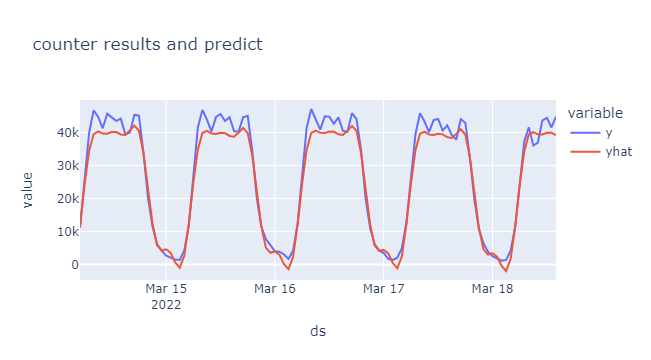

In [38]:
fig = px.line(data_result, x=data_result.index, y=['y','yhat'], title='counter results and predict')
fig.show()

In [39]:
np.sqrt(mean_squared_error(data_result['y'],data_result['yhat']))

3222.0058325468726

хуже baseline , нужно оптимизировать параметры

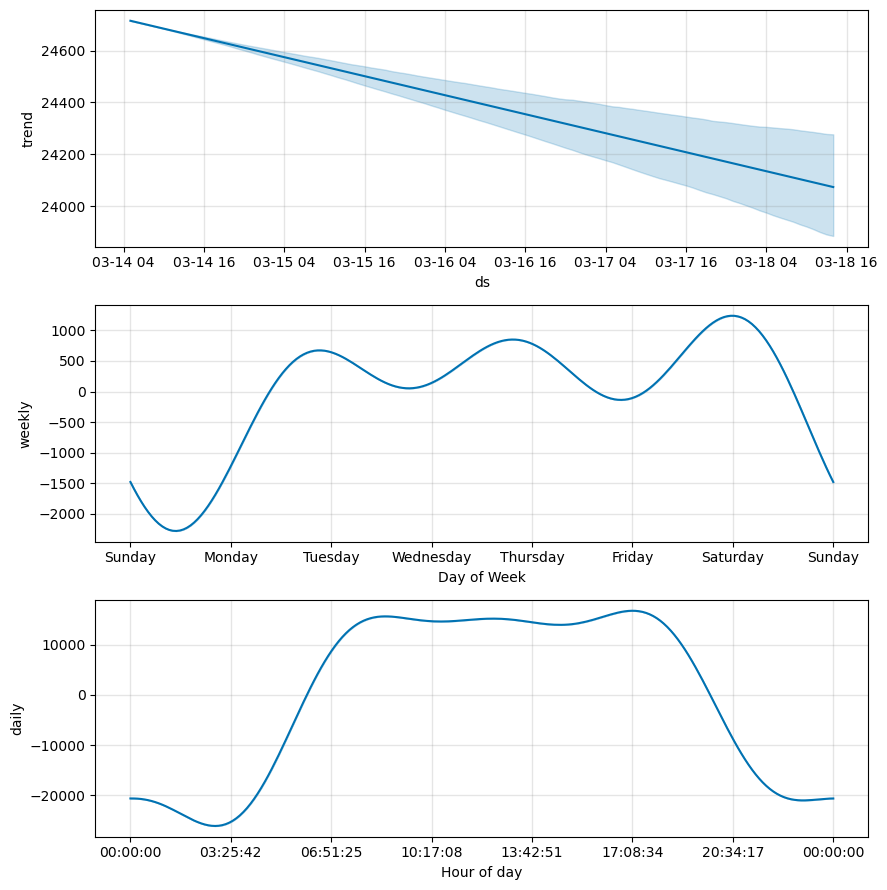

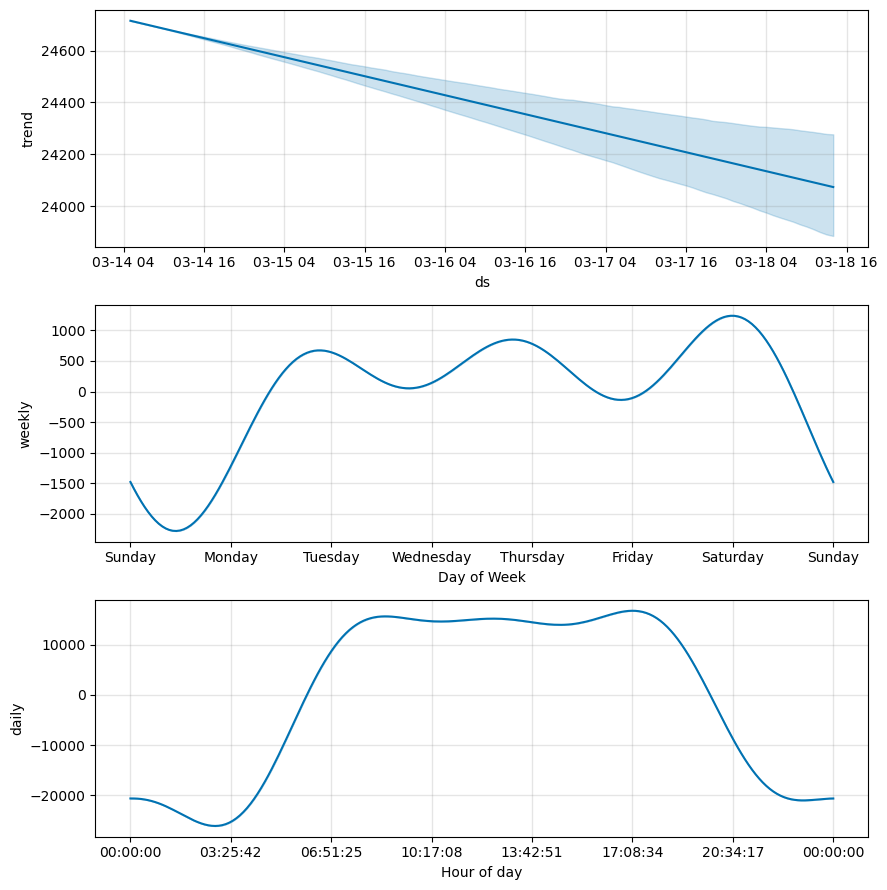

In [40]:
prophet_m.plot_components(forecast)

оно видит лёгкий трэнд , окей

а теперь кроссвалидация с подбором гипер параметров 

In [41]:
%%time
param_grid = {  
    'changepoint_prior_scale': np.linspace(0.001, 0.5, 5),
    'seasonality_prior_scale': np.linspace(0.01, 10.0, 5),
    'daily_seasonality': [24],
    'seasonality_mode': ['multiplicative']
}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Use cross validation to evaluate all parameters
def get_cv_validation_result(all_params):
    i = 0
    tuning_results = pd.DataFrame()
    for params in all_params:
        m = Prophet(changepoint_prior_scale = params['changepoint_prior_scale'],
                    seasonality_prior_scale = params['seasonality_prior_scale'],
                    daily_seasonality = params['daily_seasonality'],
                    seasonality_mode = params['seasonality_mode']).fit(tra_va_prophet)
        df_cv = cross_validation(m, initial='7 days', period='7 days', horizon = '1 days', parallel="processes")
        # проверить результат по сравнению с использованием и без диапазона initial days
        
        df_p = performance_metrics(df_cv, rolling_window=1)
        print('Params:\n', params, '\n')
        print('Result:\n', df_p, '\n')
        # Объединяем результаты с набором параметров
        result = df_p.drop(columns=['horizon']).set_index(pd.Index([i]))
        result = result.join(pd.DataFrame(params, index=[i]))
        tuning_results = tuning_results.append(result)
        i += 1
    return tuning_results
tuning_results = get_cv_validation_result(all_params)

15:08:30 - cmdstanpy - INFO - Chain [1] start processing
15:08:30 - cmdstanpy - INFO - Chain [1] done processing
15:08:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:30 - cmdstanpy - INFO - Chain [1] start processing
15:08:32 - cmdstanpy - INFO - Chain [1] done processing
15:08:32 - cmdstanpy - INFO - Chain [1] start processing
15:08:32 - cmdstanpy - INFO - Chain [1] start processing
15:08:32 - cmdstanpy - INFO - Chain [1] start processing
15:08:32 - cmdstanpy - INFO - Chain [1] done processing
15:08:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:32 - cmdstanpy - INFO - Chain [1] done processing
15:08:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:32 - cmdstanpy - 

Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse          rmse          mae      mape     mdape  \
0  1 days  2.365017e+08  15378.611191  14060.19298  3.246838  0.336193   

      smape  coverage  
0  0.716348      0.75   



15:08:36 - cmdstanpy - INFO - Chain [1] done processing
15:08:36 - cmdstanpy - INFO - Chain [1] start processing
15:08:36 - cmdstanpy - INFO - Chain [1] start processing
15:08:36 - cmdstanpy - INFO - Chain [1] start processing
15:08:36 - cmdstanpy - INFO - Chain [1] done processing
15:08:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:36 - cmdstanpy - INFO - Chain [1] done processing
15:08:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:36 - cmdstanpy - INFO - Chain [1] start processing
15:08:36 - cmdstanpy - INFO - Chain [1] start processing
15:08:36 - cmdstanpy - INFO - Chain [1] done processing
15:08:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:36 - cmdstanpy - 

Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 2.5075, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  4.002880e+06  2000.719798  1407.046226  0.116438  0.060395   

      smape  coverage  
0  0.103547  0.888889   



15:08:39 - cmdstanpy - INFO - Chain [1] done processing
15:08:39 - cmdstanpy - INFO - Chain [1] start processing
15:08:39 - cmdstanpy - INFO - Chain [1] start processing
15:08:39 - cmdstanpy - INFO - Chain [1] start processing
15:08:39 - cmdstanpy - INFO - Chain [1] done processing
15:08:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:39 - cmdstanpy - INFO - Chain [1] done processing
15:08:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:39 - cmdstanpy - INFO - Chain [1] start processing
15:08:39 - cmdstanpy - INFO - Chain [1] done processing
15:08:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:39 - cmdstanpy - INFO - Chain [1] start processing
15:08:39 - cmdstanpy - 

Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.005, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  4.037171e+06  2009.271268  1415.206412  0.118358  0.060524   

      smape  coverage  
0  0.104776  0.888889   



15:08:41 - cmdstanpy - INFO - Chain [1] done processing
15:08:42 - cmdstanpy - INFO - Chain [1] start processing
15:08:42 - cmdstanpy - INFO - Chain [1] start processing
15:08:42 - cmdstanpy - INFO - Chain [1] start processing
15:08:42 - cmdstanpy - INFO - Chain [1] done processing
15:08:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:42 - cmdstanpy - INFO - Chain [1] done processing
15:08:42 - cmdstanpy - INFO - Chain [1] start processing
15:08:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:42 - cmdstanpy - INFO - Chain [1] done processing
15:08:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:42 - cmdstanpy - INFO - Chain [1] start processing
15:08:42 - cmdstanpy - 

Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 7.5024999999999995, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse        mae      mape     mdape     smape  \
0  1 days  4.048594e+06  2012.111717  1415.3341  0.117424  0.060075  0.103951   

   coverage  
0  0.888889   



15:08:44 - cmdstanpy - INFO - Chain [1] done processing
15:08:44 - cmdstanpy - INFO - Chain [1] start processing
15:08:44 - cmdstanpy - INFO - Chain [1] start processing
15:08:44 - cmdstanpy - INFO - Chain [1] start processing
15:08:44 - cmdstanpy - INFO - Chain [1] done processing
15:08:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:44 - cmdstanpy - INFO - Chain [1] done processing
15:08:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:44 - cmdstanpy - INFO - Chain [1] done processing
15:08:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:08:44 - cmdstanpy - INFO - Chain [1] start processing
15:08:44 - cmdstanpy - INFO - Chain [1] start processing
15:08:44 - cmdstanpy - 

Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape    mdape  \
0  1 days  4.045330e+06  2011.300662  1414.920992  0.117345  0.05849   

      smape  coverage  
0  0.103839  0.888889   



15:08:46 - cmdstanpy - INFO - Chain [1] start processing
15:08:46 - cmdstanpy - INFO - Chain [1] start processing
15:08:46 - cmdstanpy - INFO - Chain [1] start processing
15:08:46 - cmdstanpy - INFO - Chain [1] done processing
15:08:46 - cmdstanpy - INFO - Chain [1] done processing
15:08:46 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:08:46 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 0.01, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse          rmse           mae      mape     mdape  \
0  1 days  2.373254e+08  15405.369745  14031.952267  3.276236  0.338466   

      smape  coverage  
0  0.714104      0.75   



15:08:47 - cmdstanpy - INFO - Chain [1] done processing
15:08:47 - cmdstanpy - INFO - Chain [1] start processing
15:08:47 - cmdstanpy - INFO - Chain [1] start processing
15:08:47 - cmdstanpy - INFO - Chain [1] start processing
15:08:47 - cmdstanpy - INFO - Chain [1] done processing
15:08:47 - cmdstanpy - INFO - Chain [1] done processing
15:08:47 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:08:47 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 2.5075, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.276434e+07  3572.721179  2542.457663  0.155537  0.115759   

     smape  coverage  
0  0.16992  0.597222   



15:08:48 - cmdstanpy - INFO - Chain [1] done processing
15:08:48 - cmdstanpy - INFO - Chain [1] start processing
15:08:48 - cmdstanpy - INFO - Chain [1] start processing
15:08:48 - cmdstanpy - INFO - Chain [1] start processing
15:08:48 - cmdstanpy - INFO - Chain [1] done processing
15:08:49 - cmdstanpy - INFO - Chain [1] done processing
15:08:49 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:08:49 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 5.005, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse         mae      mape     mdape  \
0  1 days  1.279837e+07  3577.481004  2551.90349  0.155305  0.114921   

      smape  coverage  
0  0.167837  0.611111   



15:08:49 - cmdstanpy - INFO - Chain [1] done processing
15:08:50 - cmdstanpy - INFO - Chain [1] start processing
15:08:50 - cmdstanpy - INFO - Chain [1] start processing
15:08:50 - cmdstanpy - INFO - Chain [1] start processing
15:08:50 - cmdstanpy - INFO - Chain [1] done processing
15:08:50 - cmdstanpy - INFO - Chain [1] done processing
15:08:50 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:08:50 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 7.5024999999999995, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.272829e+07  3567.673235  2541.020134  0.160614  0.115932   

      smape  coverage  
0  0.180216  0.611111   



15:08:51 - cmdstanpy - INFO - Chain [1] done processing
15:08:51 - cmdstanpy - INFO - Chain [1] start processing
15:08:51 - cmdstanpy - INFO - Chain [1] start processing
15:08:51 - cmdstanpy - INFO - Chain [1] start processing
15:08:51 - cmdstanpy - INFO - Chain [1] done processing
15:08:51 - cmdstanpy - INFO - Chain [1] done processing
15:08:52 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:08:52 - cmdstanpy - INFO - Chain [1] start processing
15:08:52 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 10.0, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.277591e+07  3574.340196  2552.518528  0.156802  0.118021   

      smape  coverage  
0  0.169621  0.597222   



15:08:52 - cmdstanpy - INFO - Chain [1] start processing
15:08:52 - cmdstanpy - INFO - Chain [1] start processing
15:08:52 - cmdstanpy - INFO - Chain [1] start processing
15:08:52 - cmdstanpy - INFO - Chain [1] done processing
15:08:52 - cmdstanpy - INFO - Chain [1] done processing
15:08:52 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:08:52 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 0.01, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse          rmse           mae      mape     mdape  \
0  1 days  2.364615e+08  15377.305426  14063.598747  3.243223  0.335259   

      smape  coverage  
0  0.716674      0.75   



15:08:53 - cmdstanpy - INFO - Chain [1] done processing
15:08:53 - cmdstanpy - INFO - Chain [1] start processing
15:08:53 - cmdstanpy - INFO - Chain [1] start processing
15:08:53 - cmdstanpy - INFO - Chain [1] start processing
15:08:53 - cmdstanpy - INFO - Chain [1] done processing
15:08:53 - cmdstanpy - INFO - Chain [1] done processing
15:08:54 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:08:54 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 2.5075, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.293528e+07  3596.565403  2567.199472  0.152758  0.115768   

      smape  coverage  
0  0.161889  0.638889   



15:08:54 - cmdstanpy - INFO - Chain [1] done processing
15:08:54 - cmdstanpy - INFO - Chain [1] start processing
15:08:54 - cmdstanpy - INFO - Chain [1] start processing
15:08:54 - cmdstanpy - INFO - Chain [1] start processing
15:08:55 - cmdstanpy - INFO - Chain [1] done processing
15:08:55 - cmdstanpy - INFO - Chain [1] done processing
15:08:55 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:08:55 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 5.005, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse         mae      mape     mdape  \
0  1 days  1.323814e+07  3638.425486  2613.55726  0.153045  0.115615   

      smape  coverage  
0  0.159314     0.625   



15:08:55 - cmdstanpy - INFO - Chain [1] done processing
15:08:55 - cmdstanpy - INFO - Chain [1] start processing
15:08:55 - cmdstanpy - INFO - Chain [1] start processing
15:08:55 - cmdstanpy - INFO - Chain [1] start processing
15:08:56 - cmdstanpy - INFO - Chain [1] done processing
15:08:56 - cmdstanpy - INFO - Chain [1] done processing
15:08:56 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:08:56 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 7.5024999999999995, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.349845e+07  3674.023433  2641.277381  0.153868  0.116691   

      smape  coverage  
0  0.160141  0.638889   



15:08:57 - cmdstanpy - INFO - Chain [1] done processing
15:08:57 - cmdstanpy - INFO - Chain [1] start processing
15:08:57 - cmdstanpy - INFO - Chain [1] start processing
15:08:57 - cmdstanpy - INFO - Chain [1] start processing
15:08:57 - cmdstanpy - INFO - Chain [1] done processing
15:08:57 - cmdstanpy - INFO - Chain [1] done processing
15:08:57 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:08:57 - cmdstanpy - INFO - Chain [1] start processing
15:08:58 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 10.0, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse         mae      mape     mdape  \
0  1 days  1.333021e+07  3651.056537  2621.90928  0.154287  0.116083   

      smape  coverage  
0  0.161575  0.652778   



15:08:58 - cmdstanpy - INFO - Chain [1] start processing
15:08:58 - cmdstanpy - INFO - Chain [1] start processing
15:08:58 - cmdstanpy - INFO - Chain [1] start processing
15:08:58 - cmdstanpy - INFO - Chain [1] done processing
15:08:58 - cmdstanpy - INFO - Chain [1] done processing
15:08:58 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:08:58 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.37525, 'seasonality_prior_scale': 0.01, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse          rmse           mae      mape     mdape  \
0  1 days  2.365910e+08  15381.513678  14040.321674  3.256879  0.337565   

      smape  coverage  
0  0.715328      0.75   



15:08:58 - cmdstanpy - INFO - Chain [1] done processing
15:08:59 - cmdstanpy - INFO - Chain [1] start processing
15:08:59 - cmdstanpy - INFO - Chain [1] start processing
15:08:59 - cmdstanpy - INFO - Chain [1] start processing
15:08:59 - cmdstanpy - INFO - Chain [1] done processing
15:08:59 - cmdstanpy - INFO - Chain [1] done processing
15:08:59 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:08:59 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.37525, 'seasonality_prior_scale': 2.5075, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.366015e+07  3695.963447  2674.882335  0.152557  0.115324   

      smape  coverage  
0  0.156865  0.652778   



15:09:00 - cmdstanpy - INFO - Chain [1] done processing
15:09:00 - cmdstanpy - INFO - Chain [1] start processing
15:09:00 - cmdstanpy - INFO - Chain [1] start processing
15:09:00 - cmdstanpy - INFO - Chain [1] start processing
15:09:00 - cmdstanpy - INFO - Chain [1] done processing
15:09:00 - cmdstanpy - INFO - Chain [1] done processing
15:09:00 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:09:01 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.37525, 'seasonality_prior_scale': 5.005, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape    mdape  \
0  1 days  1.358100e+07  3685.241183  2669.842525  0.152393  0.11187   

      smape  coverage  
0  0.156317  0.680556   



15:09:01 - cmdstanpy - INFO - Chain [1] done processing
15:09:01 - cmdstanpy - INFO - Chain [1] start processing
15:09:01 - cmdstanpy - INFO - Chain [1] start processing
15:09:01 - cmdstanpy - INFO - Chain [1] start processing
15:09:02 - cmdstanpy - INFO - Chain [1] done processing
15:09:02 - cmdstanpy - INFO - Chain [1] done processing
15:09:02 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:09:02 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.37525, 'seasonality_prior_scale': 7.5024999999999995, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae     mape     mdape  \
0  1 days  1.362450e+07  3691.137895  2667.138306  0.15153  0.115737   

      smape  coverage  
0  0.155038  0.652778   



15:09:02 - cmdstanpy - INFO - Chain [1] done processing
15:09:03 - cmdstanpy - INFO - Chain [1] start processing
15:09:03 - cmdstanpy - INFO - Chain [1] start processing
15:09:03 - cmdstanpy - INFO - Chain [1] start processing
15:09:03 - cmdstanpy - INFO - Chain [1] done processing
15:09:03 - cmdstanpy - INFO - Chain [1] done processing
15:09:03 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:09:03 - cmdstanpy - INFO - Chain [1] start processing
15:09:03 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.37525, 'seasonality_prior_scale': 10.0, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse        rmse         mae      mape     mdape     smape  \
0  1 days  1.356128e+07  3682.56482  2656.19828  0.152266  0.115732  0.157154   

   coverage  
0  0.680556   



15:09:04 - cmdstanpy - INFO - Chain [1] start processing
15:09:04 - cmdstanpy - INFO - Chain [1] start processing
15:09:04 - cmdstanpy - INFO - Chain [1] start processing
15:09:04 - cmdstanpy - INFO - Chain [1] done processing
15:09:04 - cmdstanpy - INFO - Chain [1] done processing
15:09:04 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:09:04 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse          rmse           mae      mape     mdape  \
0  1 days  2.372097e+08  15401.612653  13994.514841  3.285261  0.335758   

      smape  coverage  
0  0.712683  0.722222   



15:09:04 - cmdstanpy - INFO - Chain [1] done processing
15:09:04 - cmdstanpy - INFO - Chain [1] start processing
15:09:04 - cmdstanpy - INFO - Chain [1] start processing
15:09:04 - cmdstanpy - INFO - Chain [1] start processing
15:09:05 - cmdstanpy - INFO - Chain [1] done processing
15:09:05 - cmdstanpy - INFO - Chain [1] done processing
15:09:05 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:09:05 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 2.5075, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape    mdape  \
0  1 days  1.368363e+07  3699.138951  2672.624732  0.151688  0.11658   

      smape  coverage  
0  0.154871  0.638889   



15:09:05 - cmdstanpy - INFO - Chain [1] done processing
15:09:05 - cmdstanpy - INFO - Chain [1] start processing
15:09:05 - cmdstanpy - INFO - Chain [1] start processing
15:09:05 - cmdstanpy - INFO - Chain [1] start processing
15:09:06 - cmdstanpy - INFO - Chain [1] done processing
15:09:06 - cmdstanpy - INFO - Chain [1] done processing
15:09:06 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:09:06 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.005, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.364553e+07  3693.985151  2673.608873  0.149999  0.116467   

      smape  coverage  
0  0.152723  0.680556   



15:09:06 - cmdstanpy - INFO - Chain [1] done processing
15:09:07 - cmdstanpy - INFO - Chain [1] start processing
15:09:07 - cmdstanpy - INFO - Chain [1] start processing
15:09:07 - cmdstanpy - INFO - Chain [1] start processing
15:09:07 - cmdstanpy - INFO - Chain [1] done processing
15:09:07 - cmdstanpy - INFO - Chain [1] done processing
15:09:07 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

15:09:07 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7.5024999999999995, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.361537e+07  3689.901719  2674.138254  0.148753  0.116061   

      smape  coverage  
0  0.150241  0.680556   



15:09:08 - cmdstanpy - INFO - Chain [1] done processing
15:09:08 - cmdstanpy - INFO - Chain [1] start processing
15:09:08 - cmdstanpy - INFO - Chain [1] start processing
15:09:08 - cmdstanpy - INFO - Chain [1] start processing
15:09:08 - cmdstanpy - INFO - Chain [1] done processing
15:09:08 - cmdstanpy - INFO - Chain [1] done processing
15:09:09 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.369600e+07  3700.810403  2676.120983  0.149558  0.116852   

      smape  coverage  
0  0.151488  0.694444   

CPU times: user 4.9 s, sys: 3.44 s, total: 8.34 s
Wall time: 38.6 s


<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [42]:
tuning_results

mse          rmse           mae      mape     mdape     smape  \
0   2.365017e+08  15378.611191  14060.192980  3.246838  0.336193  0.716348   
1   4.002880e+06   2000.719798   1407.046226  0.116438  0.060395  0.103547   
2   4.037171e+06   2009.271268   1415.206412  0.118358  0.060524  0.104776   
3   4.048594e+06   2012.111717   1415.334100  0.117424  0.060075  0.103951   
4   4.045330e+06   2011.300662   1414.920992  0.117345  0.058490  0.103839   
5   2.373254e+08  15405.369745  14031.952267  3.276236  0.338466  0.714104   
6   1.276434e+07   3572.721179   2542.457663  0.155537  0.115759  0.169920   
7   1.279837e+07   3577.481004   2551.903490  0.155305  0.114921  0.167837   
8   1.272829e+07   3567.673235   2541.020134  0.160614  0.115932  0.180216   
9   1.277591e+07   3574.340196   2552.518528  0.156802  0.118021  0.169621   
10  2.364615e+08  15377.305426  14063.598747  3.243223  0.335259  0.716674   
11  1.293528e+07   3596.565403   2567.199472  0.152758  0.115768  0.161889   
12  1.323814e+07   3638.425486   2613.557260  0.153045  0.115615  0.159314   
13  1.349845e+07   3674.023433   2641.277381  0.153868  0.116691  0.160141   
14  1.333021e+07   3651.056537   2621.909280  0.154287  0.116083  0.161575   
15  2.365910e+08  15381.513678  14040.321674  3.256879  0.337565  0.715328   
16  1.366015e+07   3695.963447   2674.882335  0.152557  0.115324  0.156865   
17  1.358100e+07   3685.241183   2669.842525  0.152393  0.111870  0.156317   
18  1.362450e+07   3691.137895   2667.138306  0.151530  0.115737  0.155038   
19  1.356128e+07   3682.564820   2656.198280  0.152266  0.115732  0.157154   
20  2.372097e+08  15401.612653  13994.514841  3.285261  0.335758  0.712683   
21  1.368363e+07   3699.138951   2672.624732  0.151688  0.116580  0.154871   
22  1.364553e+07   3693.985151   2673.608873  0.149999  0.116467  0.152723   
23  1.361537e+07   3689.901719   2674.138254  0.148753  0.116061  0.150241   
24  1.369600e+07   3700.810403   2676.120983  0.149558  0.116852  0.151488   

    coverage  changepoint_prior_scale  seasonality_prior_scale  \
0   0.750000                  0.00100                   0.0100   
1   0.888889                  0.00100                   2.5075   
2   0.888889                  0.00100                   5.0050   
3   0.888889                  0.00100                   7.5025   
4   0.888889                  0.00100                  10.0000   
5   0.750000                  0.12575                   0.0100   
6   0.597222                  0.12575                   2.5075   
7   0.611111                  0.12575                   5.0050   
8   0.611111                  0.12575                   7.5025   
9   0.597222                  0.12575                  10.0000   
10  0.750000                  0.25050                   0.0100   
11  0.638889                  0.25050                   2.5075   
12  0.625000                  0.25050                   5.0050   
13  0.638889                  0.25050                   7.5025   
14  0.652778                  0.25050                  10.0000   
15  0.750000                  0.37525                   0.0100   
16  0.652778                  0.37525                   2.5075   
17  0.680556                  0.37525                   5.0050   
18  0.652778                  0.37525                   7.5025   
19  0.680556                  0.37525                  10.0000   
20  0.722222                  0.50000                   0.0100   
21  0.638889                  0.50000                   2.5075   
22  0.680556                  0.50000                   5.0050   
23  0.680556                  0.50000                   7.5025   
24  0.694444                  0.50000                  10.0000   

    daily_seasonality seasonality_mode  
0                  24   multiplicative  
1                  24   multiplicative  
2                  24   multiplicative  
3                  24   multiplicative  
4                  24   multiplicative  
5                  24

In [43]:
best_params = all_params[np.argmin(tuning_results['rmse'])]
print('Минимальное RMSE = ', tuning_results.loc[np.argmin(tuning_results['rmse'])].rmse,'\n')
print('Параметры лучшей модели:', best_params)

Минимальное RMSE =  2000.7197977286303 

Параметры лучшей модели: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 2.5075, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'}


окей уже лучше , преодалели baseline

In [44]:
best_model = Prophet(**best_params)

посмторим как в целом выглядит предикт и как модель работает с сезонностью

15:09:09 - cmdstanpy - INFO - Chain [1] start processing
15:09:09 - cmdstanpy - INFO - Chain [1] done processing
15:09:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:09:09 - cmdstanpy - INFO - Chain [1] start processing
15:09:10 - cmdstanpy - INFO - Chain [1] done processing


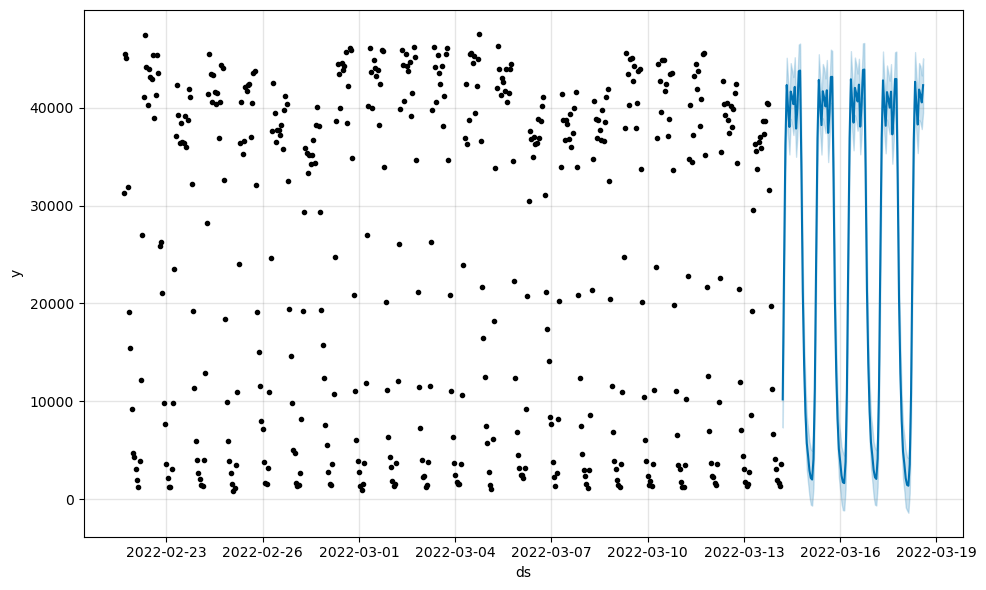

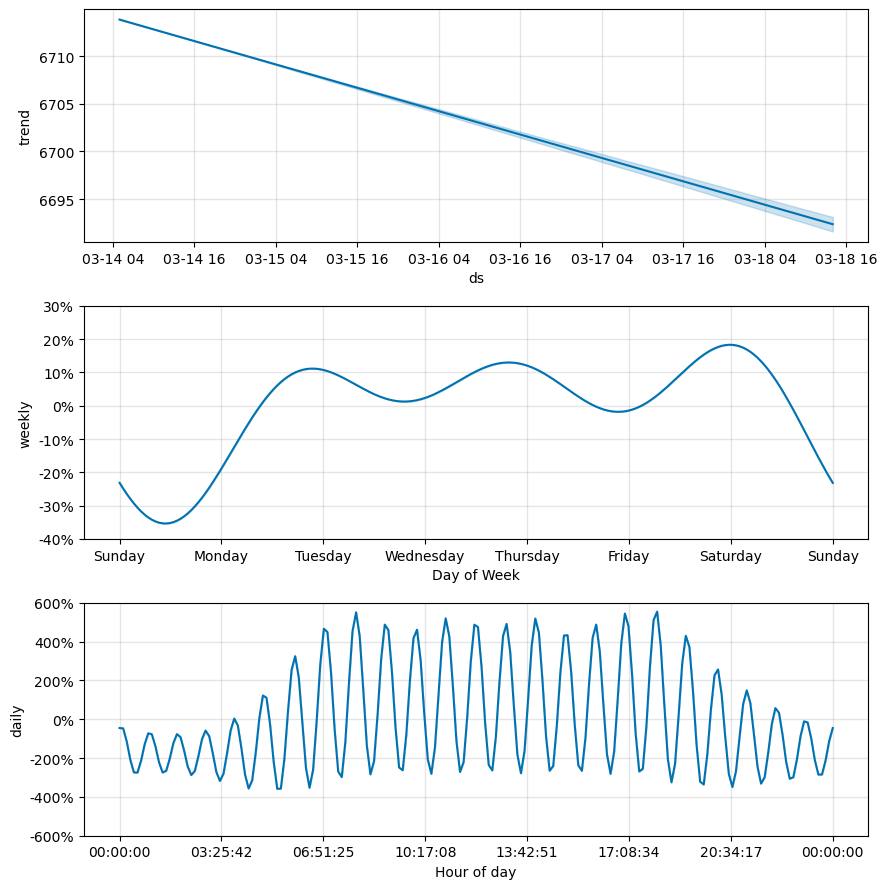

In [45]:
best_model.fit(train_prophet)
forecast = best_model.predict(valid_prophet[['ds']])
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(valid_prophet.set_index('ds'))
plot1 = best_model.plot(forecast)
plot2 = best_model.plot_components(forecast)
plot1.show()
plot2.show()

хм , вроде негативно не влияет на результат , но график часовой довольно сильно колбасит 

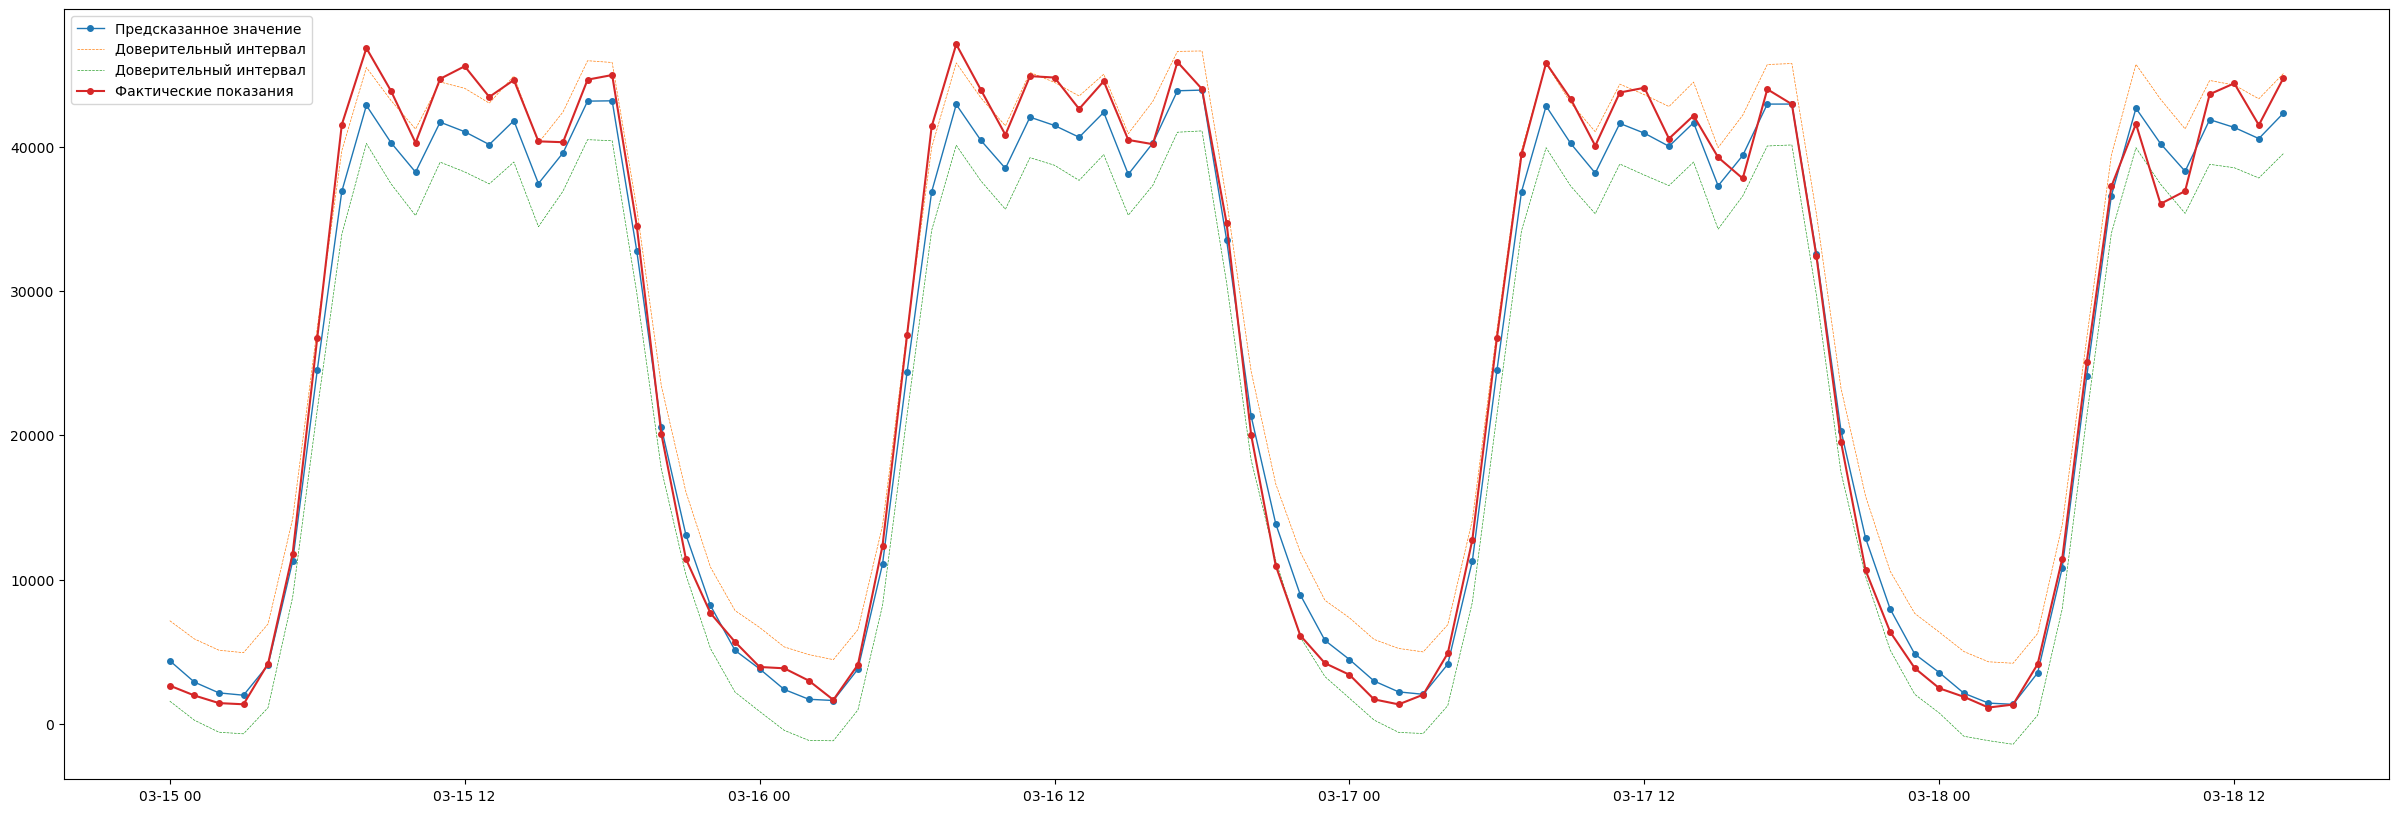

In [46]:
start, end = '2022-03-15 0:00', '2022-03-19 23:50'
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)
ax.plot(cmp_df['yhat'].loc[start:end], marker='.', linestyle='-', markersize=8, linewidth=1, label='Предсказанное значение')
ax.plot(cmp_df[['yhat_upper','yhat_lower']].loc[start:end], linestyle='--', linewidth=0.5, label='Доверительный интервал')
ax.plot(cmp_df.loc[start:end].y , marker='o', markersize=4, linestyle='-', label='Фактические показания')
ax.legend();

In [47]:
np.sqrt(mean_squared_error(cmp_df['y'],cmp_df['yhat']))

2185.7097095586337

такое ощущение что модель занижает , проверим это

In [48]:
def mean_percentage_error(actual, forecast):
    """
    Calculate Mean Percentage Error (MPE).

    Parameters:
        actual (list or array): The actual values of the time series.
        forecast (list or array): The forecasted values of the time series.

    Returns:
        float: The Mean Percentage Error (MPE) value.
    """
    if len(actual) != len(forecast):
        raise ValueError("Length of actual and forecast must be the same.")

    total_percentage_error = 0
    for i in range(len(actual)):
        if actual[i] != 0:  # Avoid division by zero
            percentage_error = (actual[i] - forecast[i]) / actual[i]
            total_percentage_error += percentage_error

    mpe = (total_percentage_error / len(actual)) * 100
    return mpe

In [49]:
mpe_value = mean_percentage_error(cmp_df['y'],cmp_df['yhat'])
print("Mean Percentage Error (MPE):", mpe_value)

Mean Percentage Error (MPE): -2.78642945784339


угу занижает , честно говоря не знаю как можно это исправить , но детекция была произведена 

15:09:12 - cmdstanpy - INFO - Chain [1] start processing
15:09:12 - cmdstanpy - INFO - Chain [1] start processing
15:09:12 - cmdstanpy - INFO - Chain [1] done processing
15:09:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:09:12 - cmdstanpy - INFO - Chain [1] done processing
15:09:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:09:12 - cmdstanpy - INFO - Chain [1] start processing
15:09:12 - cmdstanpy - INFO - Chain [1] start processing
15:09:12 - cmdstanpy - INFO - Chain [1] done processing
15:09:13 - cmdstanpy - INFO - Chain [1] done processing


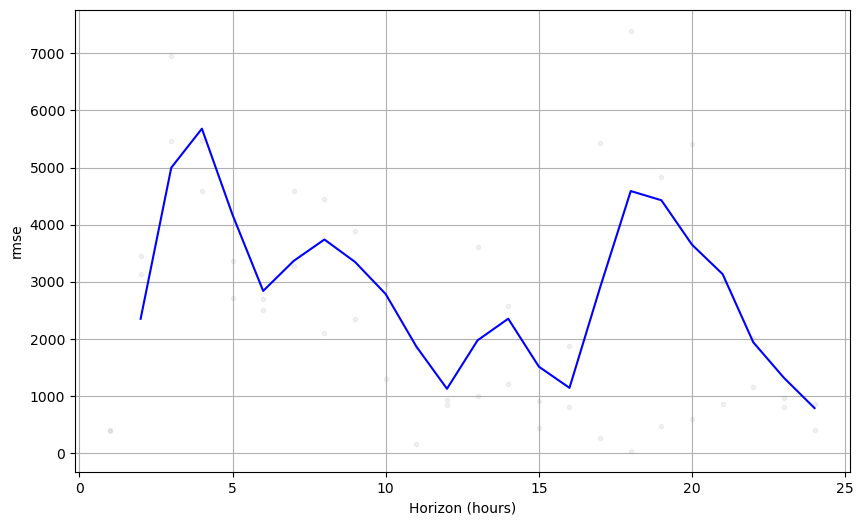

In [50]:
df_cv = cross_validation(best_model, initial='7 days', period='7 days', horizon = '1 days', parallel="processes")
fig1 = plot_cross_validation_metric(df_cv, metric='rmse')

самая большая ошибка там где происходят изменения счётчика довольно сильные

вывод по prothet : модель имеет свои недостатки , ей свойственно занижать результат , но baseline преодолела , давайте рассмотрим ещё пару различных подходов

## Обучение rnn

вступление : данных для обучения rnn очень мало , поэтому возможно покажет значение хуже профета

копируем , для дальнейшего преобразования

In [51]:
rnn_data = data
rnn_data

counter_data
counter_timestamp                
2022-02-21 16:00:00  31271.630001
2022-02-21 17:00:00  45465.502000
2022-02-21 18:00:00  45091.751334
2022-02-21 19:00:00  31916.051666
2022-02-21 20:00:00  19101.347001
...                           ...
2022-03-22 20:00:00  19620.574334
2022-03-22 21:00:00  15462.083333
2022-03-22 22:00:00  11133.987069
2022-03-22 23:00:00   6881.049907
2022-03-23 00:00:00   1618.347667

[705 rows x 1 columns]

сделаем функцию которая добавляет следующие фичи: час,день недели , скользящее среднее , и какие показатели были за 1-4 суток до этого  
<br> важный нюанс в rnn мы будем подавать только показатели значений за 1-4 суток до этого , остальное нужно для catboost

In [52]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(24, max_lag + 1):
        data['lag_{}'.format(lag)] = data['counter_data'].shift(lag)
    data['rolling_mean'] = data['lag_24'].rolling(rolling_mean_size).mean()

make_features(data, 96, 5)

In [53]:
data = data.dropna()

In [54]:
data

counter_data  hour  dayofweek        lag_24  \
counter_timestamp                                                  
2022-02-25 16:00:00  40480.320333    16          4  40611.544000   
2022-02-25 17:00:00  43515.934999    17          4  44379.223333   
2022-02-25 18:00:00  43783.852000    18          4  44041.429667   
2022-02-25 19:00:00  32130.568667    19          4  32656.306667   
2022-02-25 20:00:00  19087.255667    20          4  18373.369667   
...                           ...   ...        ...           ...   
2022-03-22 20:00:00  19620.574334    20          1  19698.491999   
2022-03-22 21:00:00  15462.083333    21          1  15138.260000   
2022-03-22 22:00:00  11133.987069    22          1  11277.455334   
2022-03-22 23:00:00   6881.049907    23          1   7740.329333   
2022-03-23 00:00:00   1618.347667     0          2   6063.174790   

                           lag_25        lag_26        lag_27        lag_28  \
counter_timestamp                                                             
2022-02-25 16:00:00  36898.569667  41524.386000  40395.365333  41628.574667   
2022-02-25 17:00:00  40611.544000  36898.569667  41524.386000  40395.365333   
2022-02-25 18:00:00  44379.223333  40611.544000  36898.569667  41524.386000   
2022-02-25 19:00:00  44041.429667  44379.223333  40611.544000  36898.569667   
2022-02-25 20:00:00  32656.306667  44041.429667  44379.223333  40611.544000   
...                           ...           ...           ...           ...   
2022-03-22 20:00:00  32903.677333  43654.449333  44488.716333  38442.651334   
2022-03-22 21:00:00  19698.491999  32903.677333  43654.449333  44488.716333   
2022-03-22 22:00:00  15138.260000  19698.491999  32903.677333  43654.449333   
2022-03-22 23:00:00  11277.455334  15138.260000  19698.491999  32903.677333   
2022-03-23 00:00:00   7740.329333  11277.455334  15138.260000  19698.491999   

                           lag_29        lag_30  ...        lag_88  \
counter_timestamp                                ...                 
2022-02-25 16:00:00  43300.895667  40555.862999  ...   4250.166333   
2022-02-25 17:00:00  41628.574667  43300.895667  ...   3112.549000   
2022-02-25 18:00:00  40395.365333  41628.574667  ...   1937.366333   
2022-02-25 19:00:00  41524.386000  40395.365333  ...   1261.371666   
2022-02-25 20:00:00  36898.569667  41524.386000  ...   3924.515666   
...                           ...           ...  ...           ...   
2022-03-22 20:00:00  40564.140666  45037.947666  ...   3500.006000   
2022-03-22 21:00:00  38442.651334  40564.140666  ...  10097.217001   
2022-03-22 22:00:00  44488.716333  38442.651334  ...  23265.182666   
2022-03-22 23:00:00  43654.449333  44488.716333  ...  35663.914999   
2022-03-23 00:00:00  32903.677333  43654.449333  ...  42593.398000   

                           lag_89        lag_90        lag_91        lag_92  \
counter_timestamp                                                             
2022-02-25 16:00:00   4704.634667   9179.332000  15408.110667  19101.347001   
2022-02-25 17:00:00   4250.166333   4704.634667   9179.332000  15408.110667   
2022-02-25 18:00:00   3112.549000   4250.166333   4704.634667   9179.332000   
2022-02-25 19:00:00   1937.366333   3112.549000   4250.166333   4704.634667   
2022-02-25 20:00:00   1261.371666   1937.366333   3112.549000   4250.166333   
...                           ...           ...           ...           ...   
2022-03-22 20:00:00   1296.752000   1059.594666   2202.621666   2605.529333   
2022-03-22 21:00:00   3500.006000   1296.752000   1059.594666   2202.621666   
2022-03-22 22:00:00  10097.217001   3500.006000   1296.752000   1059.594666   
2022-03-22 23:00:00  23265.182666  10097.217001   3500.006000   1296.752000   
2022-03-23 00:00:00  35663.914999  23265.182666  10097.217001   3500.006000   

                           lag_93        lag_94        lag_95        lag_96  \
counter_timestamp                                                             
2022-02-25 

выбираем столбцы для обучения и таргет

In [55]:
rnn_x = data.filter(like="lag").columns 
rnn_y = data.filter(like="counter_data").columns

ещё раз делим данные , важный нюанс на валидации и тесте количество данных не должно поменяться

In [56]:
tra_va, test = temporal_train_test_split(data,test_size = 0.174)
train, valid = temporal_train_test_split(tra_va,test_size = 0.21)

In [57]:
print(data.shape)
print(train.shape)
print(valid.shape)
test.shape

(609, 77)
(397, 77)
(106, 77)


(106, 77)

производим стандартизацию (это надо только для нейронок) доп комментарий , я здесь затупил , можно было обойтись 1 StandardScaler

In [58]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()
scaled_train_x = scaler_x.fit_transform(train[rnn_x])
scaled_valid_x = scaler_x.transform(valid[rnn_x])
scaled_test_x = scaler_x.transform(test[rnn_x])
scaled_train_y = scaler_y.fit_transform(train[rnn_y])
scaled_valid_y = scaler_y.transform(valid[rnn_y])
scaled_test_y = scaler_y.transform(test[rnn_y])

очень жаль что 4 недели всего данных( было бы больше данных , можно было бы взять и запихнуть период в неделю , а так придётся использовать 3 дня (чтобы не отбрасывать 25% данных из обучения)

а теперь само построение нейронки будем использовать 2 слоя LSTM

In [59]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(73, 1),return_sequences = True))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(0.001), loss='mse')

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 73, 200)           161600    
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________


установим пару полезных фич валидация и ранняя остановка

In [61]:
earlystop_callb = EarlyStopping(monitor='val_loss',
                                patience=50,
                                )
checkpoint_callb = ModelCheckpoint(filepath='model_targ0.h5',
                                   monitor='val_loss',
                                   save_best_only=True)

reducelr_callb = ReduceLROnPlateau(monitor = 'val_loss', 
                                   factor=0.1,
                                   patience=30,
                                   verbose=1)

In [62]:
#model.fit(scaled_train_x,scaled_train_y,epochs=1000,validation_data=(scaled_valid_x, scaled_valid_y),batch_size=7, 
#                                         callbacks=[reducelr_callb,
#                                                    checkpoint_callb,
#                                                    earlystop_callb
#                                         ])

In [63]:
#если захотите запустить модель рассколентируйте 2 ячейки
#loss_per_epoch = model.history.history['loss']
#plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [64]:
model_best_rnn = load_model('model_targ0.h5')

In [65]:
pr = model_best_rnn.predict(scaled_valid_x)

4/4 [==============================] - 0s 30ms/step


In [66]:
true_predictions = scaler_y.inverse_transform(pr)

In [67]:
np.sqrt(mean_squared_error(valid[rnn_y],true_predictions))

2181.8890144071115

минимальное значение 1966 на валидации удалось получить , лучше чем профет (эту модельку я сохранил)

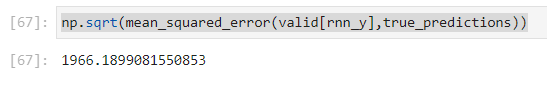

In [68]:
plot_data = valid[rnn_y]

In [69]:
plot_data['pred'] = true_predictions

/tmp/ipykernel_75/4250020881.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
plot_data

counter_data          pred
counter_timestamp                              
2022-03-14 05:00:00  11145.998000  11029.192383
2022-03-14 06:00:00  24871.138667  25518.878906
2022-03-14 07:00:00  39697.814666  37959.062500
2022-03-14 08:00:00  46679.943333  44228.972656
2022-03-14 09:00:00  44757.724667  45568.320312
...                           ...           ...
2022-03-18 10:00:00  36913.975000  43537.476562
2022-03-18 11:00:00  43621.235667  43448.066406
2022-03-18 12:00:00  44376.084333  42501.121094
2022-03-18 13:00:00  41484.943666  41609.703125
2022-03-18 14:00:00  44743.147000  40942.921875

[106 rows x 2 columns]

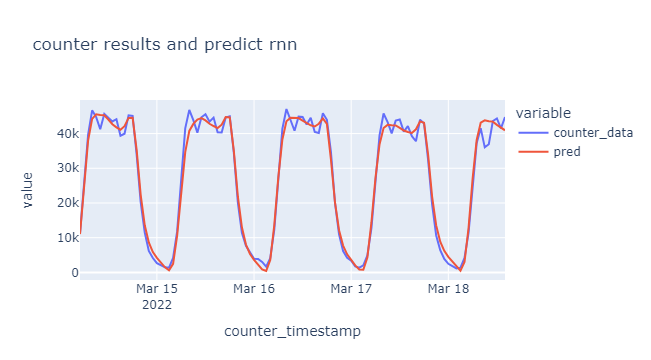

In [71]:
fig = px.line(plot_data, x=plot_data.index, y=['counter_data','pred'], title='counter results and predict rnn')
fig.show()

вот график самих предиктов и истинного значения , здесь не занижает , но надо поиграться со структурой как мне кажется

## Обучение CatBoost

последний подход catboost

In [72]:
tra_va[['counter_data']]

counter_data
counter_timestamp                
2022-02-25 16:00:00  40480.320333
2022-02-25 17:00:00  43515.934999
2022-02-25 18:00:00  43783.852000
2022-02-25 19:00:00  32130.568667
2022-02-25 20:00:00  19087.255667
...                           ...
2022-03-18 10:00:00  36913.975000
2022-03-18 11:00:00  43621.235667
2022-03-18 12:00:00  44376.084333
2022-03-18 13:00:00  41484.943666
2022-03-18 14:00:00  44743.147000

[503 rows x 1 columns]

будем использовать все фичи которые сгенерировали раннее 

In [73]:
cb_model = CatBoostRegressor(max_depth=8, iterations=1000,
                             early_stopping_rounds=20,
                             objective="RMSE",
                             learning_rate = 0.01,
                             verbose=10,
                             random_state=1)

cb_model.fit(train.drop("counter_data",axis = 1), train[['counter_data']], eval_set=(valid.drop("counter_data",axis = 1), valid[['counter_data']]))

0:	learn: 16681.3160846	test: 17484.5417695	best: 17484.5417695 (0)	total: 103ms	remaining: 1m 43s
10:	learn: 15389.7756438	test: 16216.6326660	best: 16216.6326660 (10)	total: 313ms	remaining: 28.1s
20:	learn: 14188.7041255	test: 15037.3939905	best: 15037.3939905 (20)	total: 504ms	remaining: 23.5s
30:	learn: 13093.0999582	test: 13945.4450923	best: 13945.4450923 (30)	total: 698ms	remaining: 21.8s
40:	learn: 12088.6911073	test: 12941.0258613	best: 12941.0258613 (40)	total: 905ms	remaining: 21.2s
50:	learn: 11160.8546741	test: 12024.9802015	best: 12024.9802015 (50)	total: 1.12s	remaining: 20.8s
60:	learn: 10327.3041562	test: 11190.0537658	best: 11190.0537658 (60)	total: 1.32s	remaining: 20.3s
70:	learn: 9545.3611895	test: 10409.8741435	best: 10409.8741435 (70)	total: 1.5s	remaining: 19.7s
80:	learn: 8822.3570779	test: 9691.2965842	best: 9691.2965842 (80)	total: 1.7s	remaining: 19.3s
90:	learn: 8178.1662130	test: 9050.8878714	best: 9050.8878714 (90)	total: 1.89s	remaining: 18.9s
100:	learn

In [74]:
pr = cb_model.predict(valid.drop("counter_data",axis = 1))

In [75]:
plot_data['pred'] = pr

/tmp/ipykernel_75/2168426009.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



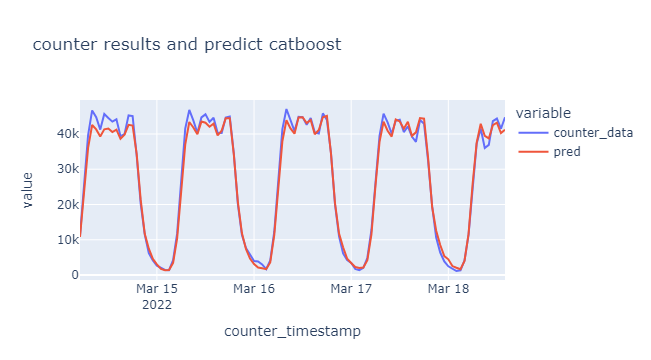

In [76]:
fig = px.line(plot_data, x=plot_data.index, y=['counter_data','pred'], title='counter results and predict catboost')
fig.show()

лучшая валидация 1700 , получается лучший подход? ну-ка взляним на что опирается модель

## Интерпретация CatBoostRegressor

In [77]:
shap.initjs()

добавляем предикт к основным столбцам

In [78]:
tra_va['y_pred'] = cb_model.predict(tra_va.drop("counter_data",axis = 1))

In [79]:
tra_va

counter_data  hour  dayofweek        lag_24  \
counter_timestamp                                                  
2022-02-25 16:00:00  40480.320333    16          4  40611.544000   
2022-02-25 17:00:00  43515.934999    17          4  44379.223333   
2022-02-25 18:00:00  43783.852000    18          4  44041.429667   
2022-02-25 19:00:00  32130.568667    19          4  32656.306667   
2022-02-25 20:00:00  19087.255667    20          4  18373.369667   
...                           ...   ...        ...           ...   
2022-03-18 10:00:00  36913.975000    10          4  40050.031666   
2022-03-18 11:00:00  43621.235667    11          4  43739.735667   
2022-03-18 12:00:00  44376.084333    12          4  44069.869334   
2022-03-18 13:00:00  41484.943666    13          4  40546.430999   
2022-03-18 14:00:00  44743.147000    14          4  42138.939667   

                           lag_25        lag_26        lag_27        lag_28  \
counter_timestamp                                                             
2022-02-25 16:00:00  36898.569667  41524.386000  40395.365333  41628.574667   
2022-02-25 17:00:00  40611.544000  36898.569667  41524.386000  40395.365333   
2022-02-25 18:00:00  44379.223333  40611.544000  36898.569667  41524.386000   
2022-02-25 19:00:00  44041.429667  44379.223333  40611.544000  36898.569667   
2022-02-25 20:00:00  32656.306667  44041.429667  44379.223333  40611.544000   
...                           ...           ...           ...           ...   
2022-03-18 10:00:00  43297.899667  45783.968334  39451.343000  26759.929333   
2022-03-18 11:00:00  40050.031666  43297.899667  45783.968334  39451.343000   
2022-03-18 12:00:00  43739.735667  40050.031666  43297.899667  45783.968334   
2022-03-18 13:00:00  44069.869334  43739.735667  40050.031666  43297.899667   
2022-03-18 14:00:00  40546.430999  44069.869334  43739.735667  40050.031666   

                           lag_29        lag_30  ...        lag_89  \
counter_timestamp                                ...                 
2022-02-25 16:00:00  43300.895667  40555.862999  ...   4704.634667   
2022-02-25 17:00:00  41628.574667  43300.895667  ...   4250.166333   
2022-02-25 18:00:00  40395.365333  41628.574667  ...   3112.549000   
2022-02-25 19:00:00  41524.386000  40395.365333  ...   1937.366333   
2022-02-25 20:00:00  36898.569667  41524.386000  ...   1261.371666   
...                           ...           ...  ...           ...   
2022-03-18 10:00:00  12766.758667   4896.566666  ...  45269.423667   
2022-03-18 11:00:00  26759.929333  12766.758667  ...  45078.204667   
2022-03-18 12:00:00  39451.343000  26759.929333  ...  33890.541667   
2022-03-18 13:00:00  45783.968334  39451.343000  ...  20182.669001   
2022-03-18 14:00:00  43297.899667  45783.968334  ...  11496.902667   

                           lag_90        lag_91        lag_92        lag_93  \
counter_timestamp                                                             
2022-02-25 16:00:00   9179.332000  15408.110667  19101.347001  31916.051666   
2022-02-25 17:00:00   4704.634667   9179.332000  15408.110667  19101.347001   
2022-02-25 18:00:00   4250.166333   4704.634667   9179.332000  15408.110667   
2022-02-25 19:00:00   3112.549000   4250.166333   4704.634667   9179.332000   
2022-02-25 20:00:00   1937.366333   3112.549000   4250.166333   4704.634667   
...                           ...           ...           ...           ...   
2022-03-18 10:00:00  39958.400000  39390.936666  44153.382666  43502.308667   
2022-03-18 11:00:00  45269.423667  39958.400000  39390.936666  44153.382666   
2022-03-18 12:00:00  45078.204667  45269.423667  39958.400000  39390.936666   
2022-03-18 13:00:00  33890.541667  45078.204667  45269.423667  39958.400000   
2022-03-18 14:00:00  20182.669001  33890.541667  45078.204667  45269.423667   

                           lag_94        lag_95        lag_96  rolling_mean  \
counter_timestamp                                                             
2022-02-25 

In [80]:
explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(tra_va.drop("counter_data",axis = 1))

In [81]:
tra_va.drop("counter_data",axis = 1).columns

Index(['hour', 'dayofweek', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28',
       'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35',
       'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40', 'lag_41', 'lag_42',
       'lag_43', 'lag_44', 'lag_45', 'lag_46', 'lag_47', 'lag_48', 'lag_49',
       'lag_50', 'lag_51', 'lag_52', 'lag_53', 'lag_54', 'lag_55', 'lag_56',
       'lag_57', 'lag_58', 'lag_59', 'lag_60', 'lag_61', 'lag_62', 'lag_63',
       'lag_64', 'lag_65', 'lag_66', 'lag_67', 'lag_68', 'lag_69', 'lag_70',
       'lag_71', 'lag_72', 'lag_73', 'lag_74', 'lag_75', 'lag_76', 'lag_77',
       'lag_78', 'lag_79', 'lag_80', 'lag_81', 'lag_82', 'lag_83', 'lag_84',
       'lag_85', 'lag_86', 'lag_87', 'lag_88', 'lag_89', 'lag_90', 'lag_91',
       'lag_92', 'lag_93', 'lag_94', 'lag_95', 'lag_96', 'rolling_mean',
       'y_pred'],
      dtype='object')

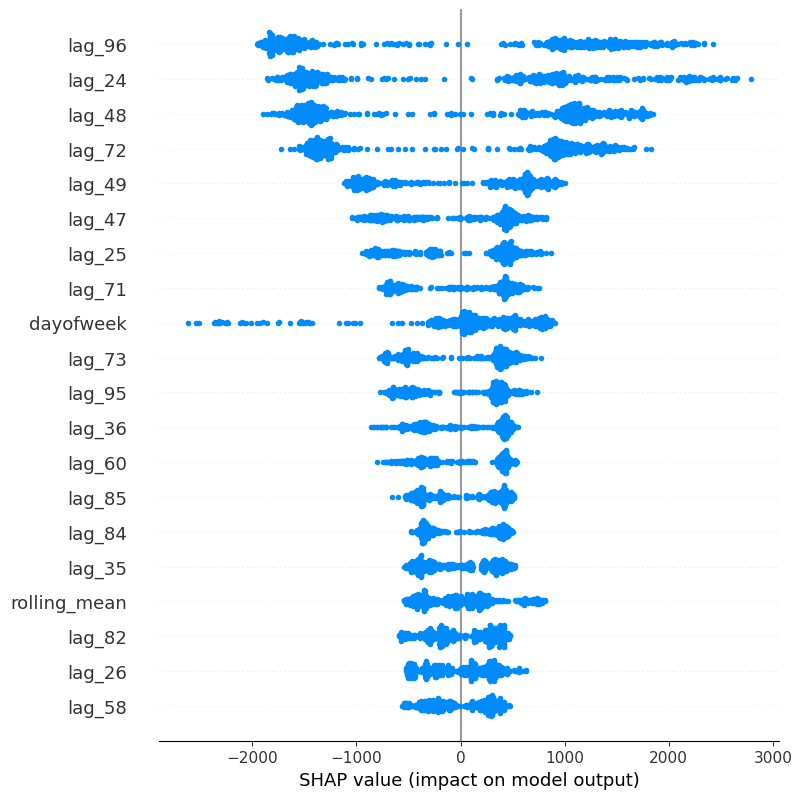

In [83]:
shap.summary_plot(shap_values, tra_va.drop("counter_data",axis = 1).columns)

важный нюанс шап делит важность фичей имеющих высокую корреляцию , здесь как раз такой случай , у нас много высококоррелированных фичей (можно сделать профилинг и показать это) следовательно стоит понимать что эти 3 фичи нужно интерпретировать как одну (при описание) . А это значит что для нашей модели важнее всего какое значение было за предыдущие 3 суток в это же время +- час , также день недели играет сильную роль

In [84]:
gr = cb_model.get_feature_importance(prettified=True)
gr

Feature Id  Importances
0      lag_24    14.402380
1      lag_96    12.843154
2      lag_72    10.593956
3      lag_48     9.287911
4   dayofweek     3.536526
..        ...          ...
71     lag_56     0.215546
72     lag_76     0.212992
73     lag_61     0.212596
74     lag_44     0.210703
75     lag_92     0.172665

[76 rows x 2 columns]

In [85]:
print('train_an')
print(tra_va.drop("counter_data",axis = 1).iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values[0,:], tra_va.drop("counter_data",axis = 1).iloc[0,:])

train_an
hour               16.000000
dayofweek           4.000000
lag_24          40611.544000
lag_25          36898.569667
lag_26          41524.386000
                    ...     
lag_94          45091.751334
lag_95          45465.502000
lag_96          31271.630001
rolling_mean    40211.687933
y_pred          39747.126447
Name: 2022-02-25 16:00:00, Length: 77, dtype: float64


вроде бы все фичи вносят свой вклад , следовательно избежали утечки таргета при добавление фичей 

## Итоговый тест и вывод

лучшая модель catboost , сейчас обучим на tra_va и сделаем предсказание на тесте

In [86]:
tra_va = tra_va.drop('y_pred',axis = 1)

In [87]:
tra_va.shape

(503, 77)

In [88]:
valid.shape

(106, 77)

<div class="alert alert-info">
<h2> Комментарий выполняющего: <a class="tocSkip"> </h2>
хоть и проверка на валидации(часть обучающих данных) переобучение должны избежать , так как используем не чрезмерное количество итераций
</div> 

In [89]:
cb_model = CatBoostRegressor(max_depth=8, iterations=850,
                             early_stopping_rounds=20, 
                             objective="RMSE", 
                             learning_rate = 0.01,
                             verbose=10,
                             random_state=1)

cb_model.fit(tra_va.drop("counter_data",axis = 1), tra_va[['counter_data']], eval_set=(valid.drop("counter_data",axis = 1), valid[['counter_data']]))

0:	learn: 16839.4091958	test: 17413.0492805	best: 17413.0492805 (0)	total: 51.1ms	remaining: 43.4s
10:	learn: 15488.5043942	test: 16069.4987992	best: 16069.4987992 (10)	total: 264ms	remaining: 20.1s
20:	learn: 14254.6640671	test: 14835.7464829	best: 14835.7464829 (20)	total: 479ms	remaining: 18.9s
30:	learn: 13111.1725646	test: 13687.0674698	best: 13687.0674698 (30)	total: 732ms	remaining: 19.3s
40:	learn: 12070.4603063	test: 12630.4227140	best: 12630.4227140 (40)	total: 973ms	remaining: 19.2s
50:	learn: 11116.0832983	test: 11667.2803044	best: 11667.2803044 (50)	total: 1.18s	remaining: 18.5s
60:	learn: 10260.1272768	test: 10795.0222804	best: 10795.0222804 (60)	total: 1.38s	remaining: 17.8s
70:	learn: 9468.6717111	test: 9992.9591618	best: 9992.9591618 (70)	total: 1.58s	remaining: 17.3s
80:	learn: 8735.3182236	test: 9251.8008680	best: 9251.8008680 (80)	total: 1.77s	remaining: 16.8s
90:	learn: 8083.4368477	test: 8588.8666460	best: 8588.8666460 (90)	total: 1.98s	remaining: 16.5s
100:	learn

создание датафрема с предиктом , для финальной визуализации

In [90]:
final_plot = cb_model.predict(data.drop("counter_data",axis = 1))

In [91]:
final_plot = pd.DataFrame({'predict':final_plot},index = data.index)

In [92]:
final_plot

predict
counter_timestamp                
2022-02-25 16:00:00  39522.086157
2022-02-25 17:00:00  43956.902372
2022-02-25 18:00:00  43420.840671
2022-02-25 19:00:00  32464.658364
2022-02-25 20:00:00  20249.265515
...                           ...
2022-03-22 20:00:00  18294.287294
2022-03-22 21:00:00  10952.210697
2022-03-22 22:00:00   6898.693440
2022-03-22 23:00:00   4938.780954
2022-03-23 00:00:00   3425.252238

[609 rows x 1 columns]

In [93]:
predict_test = cb_model.predict(test.drop("counter_data",axis = 1))

In [94]:
np.sqrt(mean_squared_error(test['counter_data'].values,predict_test))

1601.3113304237233

итог 1600 на тест (что лучше чем наивная модель)

In [95]:
np.sqrt(mean_squared_error(data['counter_data'],final_plot['predict']))

1120.1087366498841

финальная визуализация

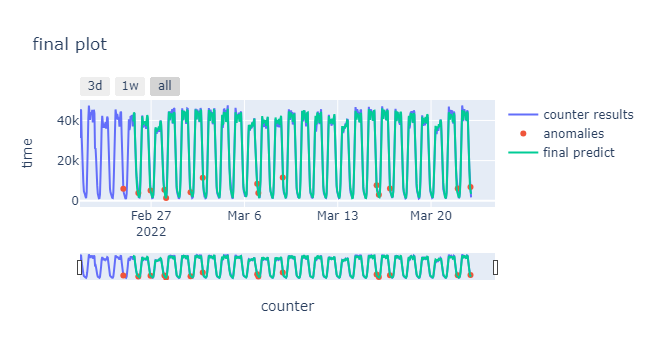

In [96]:
#x_data1 = x=data.index
x_data2 = data_out.index
x_data3 = x=final_plot.index
#y_data_1 = data['counter_data']
y_data_2 = data_out['counter_data']
y_data_3 = final_plot['predict']
# Create traces for each data set
trace1 = go.Scatter(x=x_data1, y=y_data_1, mode='lines', name='counter results')
trace3 = go.Scatter(x=x_data3, y=y_data_3, mode='lines', name='final predict')
trace2 = go.Scatter(x=x_data2, y=y_data_2, mode='markers', name='anomalies')

# Create the figure and add traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3)
# Update layout if needed (e.g., title, axis labels)
fig.update_layout(title='final plot',
                  xaxis_title='counter',
                  yaxis_title='time')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"),
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

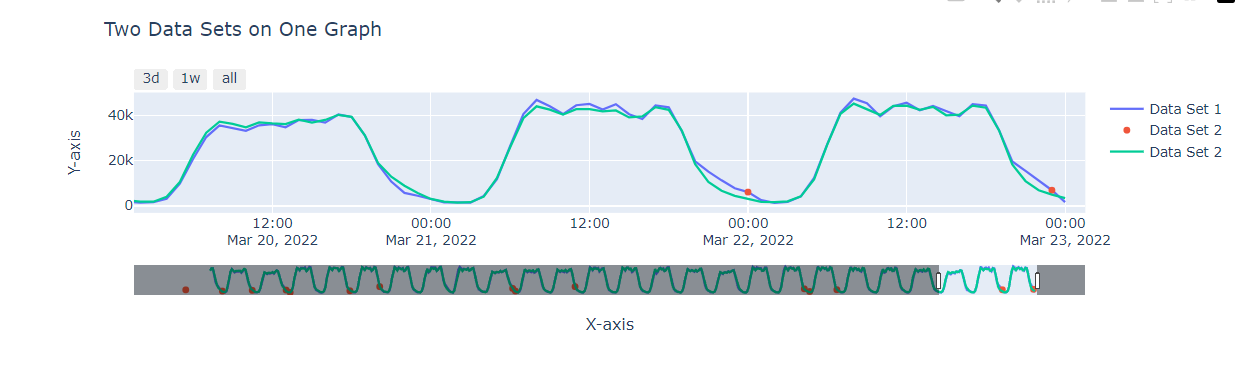

общий вывод:
основная информация с которой мы работали это показатели счётчика и времени , также для построенние некоторых моделей были сгенерированны столбцы (с скользящим среднем , часом , днём недели и данные о истиноом значение какое-то время назад(1сутки-4 суток))
<br>итог эксперементов с моделями: использовами prophet , rnn , catboost , лучше всего себя показал catboost (rmse 1600 на тесте при показателях 2900 наивной модели)
<br>Рекомендации: собрать хотя бы ещё 2 недели данных для улучшения модели